## Generating MNIST digit using GAN

A generative adversarial network (GAN) is a class of machine learning frameworks invented by Ian Goodfellow and his colleagues in 2014. GAN's are Framework where 2 Neural network compete with eachother and try to beat each other.
2 neural nework are Ganerator and Discriminator.
Generator : Generates fake data from noise
Discriminator : is trained on real data and disriminate between fake and real data

In GANs we have 2 loss functions. one for generator and one for discriminator. The discriminator must classify fakes from real images thus it is binary classification probelem thus we will use binary crossentropy. The Generator loss 

#### Loss
Here discriminator must classify fakes from real images which means we do binary classification and rhus we will use binary crossentropy

GAN are basically large neural network where during training generator we freeze disriminator layer, and we use binary cross entropy where we kep 1 as real and 0 as fake but we pass generated image as rue image.also important to remember that as disriminator is frozen loss will only chane weights of generator thus keeping discriminator weights intact.
thus loss of generator looks like this :
<img src=img/Generator_loss.png width="200" height="200">
where y(hat) are fake images but using 1 as label 

##### Input
Input to Generator is noise(e.g random vector of size 100), These vectors come from the latent space (Latent space is an imaginary space where generator believes images come from. it maps all possible images).Then Generator learns to map areas of latent space in actual images, thus Generator works in reverse of a Feature Transformer or Embedding Vector i.e for Images

Input to Discriminator is actual image 

In [1]:
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.2.0-rc4


### Basic Imports


In [0]:
# More imports
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

### Load in the data

In [3]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


### Flatten the data


In [0]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [0]:
# Dimensionality of the latent space
latent_dim = 100

### Design Generator model

In [0]:
# Get the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

### Design discriminator model


In [0]:
# Get the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

### Compile both models

In [0]:
# Compile both models in preparation for training


# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

## Train the GAN
initializing config and folder for saving intermediate files

In [0]:
# Train the GAN


# Config
batch_size = 32
epochs = 10000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

#### A function to generate a grid of random samples from the generator
this is to generate 25 digits using predition of generator current weights to check training accuracy in terms of visual confirmation

In [0]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

### Main training loop

In [12]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1/10000, d_loss: 0.64,       d_acc: 0.50, g_loss: 0.39
epoch: 101/10000, d_loss: 0.10,       d_acc: 0.98, g_loss: 3.39
epoch: 201/10000, d_loss: 0.67,       d_acc: 0.58, g_loss: 1.15
epoch: 301/10000, d_loss: 0.73,       d_acc: 0.42, g_loss: 0.59
epoch: 401/10000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.62
epoch: 501/10000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.64
epoch: 601/10000, d_loss: 0.67,       d_acc: 0.50, g_loss: 0.66
epoch: 701/10000, d_loss: 0.71,       d_acc: 0.45, g_loss: 0.67
epoch: 801/10000, d_loss: 0.67,       d_acc: 0.53, g_loss: 0.68
epoch: 901/10000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.70
epoch: 1001/10000, d_loss: 0.64,       d_acc: 0.59, g_loss: 0.72
epoch: 1101/10000, d_loss: 0.65,       d_acc: 0.56, g_loss: 0.70
epoch: 1201/10000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.77
epoch: 1301/10000, d_loss: 0.69,       d_acc: 0.52, g_loss: 0.75
epoch: 1401/10000, d_loss: 0.65,       d_acc: 0.64, g_loss: 0.75
epoch: 1501/10000, d_loss: 0.63,     

### Plot loss
here generator and discriminator are competing thus important factors should be that they remain near each other

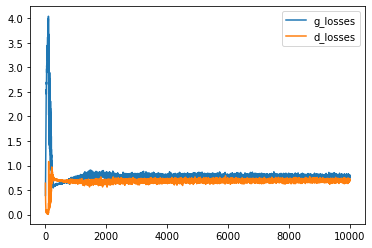

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

### check availabe images and plot 
here we plot some of image to understand how generator was trained during different phase 

In [14]:
!ls gan_images

0.png	  200.png   3400.png  4600.png	6000.png  7200.png  8400.png  9800.png
1000.png  2200.png  3600.png  4800.png	600.png   7400.png  8600.png
1200.png  2400.png  3800.png  5000.png	6200.png  7600.png  8800.png
1400.png  2600.png  4000.png  5200.png	6400.png  7800.png  9000.png
1600.png  2800.png  400.png   5400.png	6600.png  8000.png  9200.png
1800.png  3000.png  4200.png  5600.png	6800.png  800.png   9400.png
2000.png  3200.png  4400.png  5800.png	7000.png  8200.png  9600.png


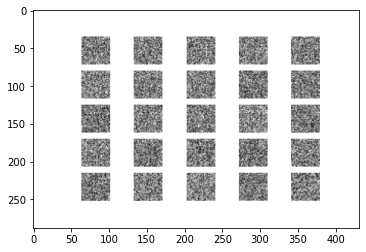

In [15]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

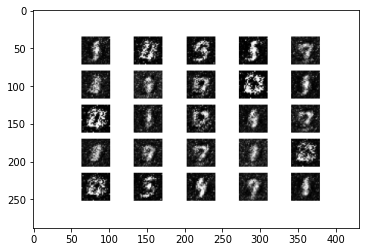

In [16]:
a = imread('gan_images/1000.png')
plt.imshow(a)

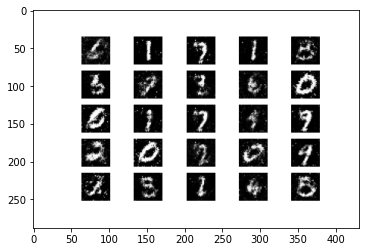

In [18]:
a = imread('gan_images/2400.png')
plt.imshow(a)

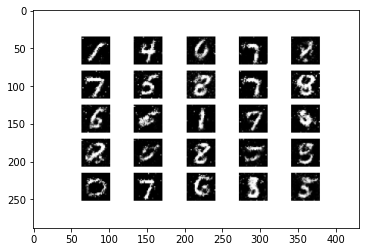

In [19]:
a = imread('gan_images/5000.png')
plt.imshow(a)

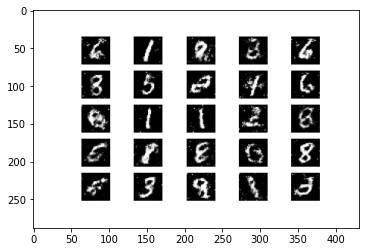

In [20]:
a = imread('gan_images/7600.png')
plt.imshow(a)

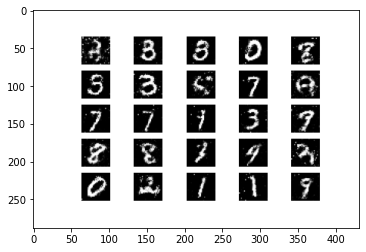

In [21]:
a = imread('gan_images/8600.png')
plt.imshow(a)

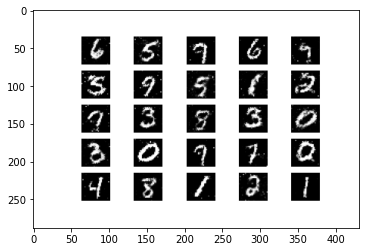

In [22]:
a = imread('gan_images/9800.png')
plt.imshow(a)